# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://st.yandex-team.ru/DS-6856).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты и константы

Импорты:

In [1]:
# pip install --upgrade pip

In [2]:
# pip install tensorflow

In [228]:
# pip install pymystem3

In [1]:
import pandas as pd
import numpy as np
#from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from PIL import Image

from pymystem3 import Mystem

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (Conv2D, 
                                     Flatten, 
                                     Dense, 
                                     AvgPool2D,
                                     GlobalAveragePooling2D,
                                     Dropout, 
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import warnings

2023-06-22 14:53:47.899379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.filterwarnings("ignore")

Констатны:

In [3]:
path = '/Users/romanandreev/Documents/DataScience/22 - Project_4/to_upload'
stop_words = ['child', 'children', 'boy', 'girl', 'boys', 'girls', 'newborn', 'baby', 'babies', 'teenager', 
              'teen', 'kid', 'teenage', 'infant', 'youngster']
seed = 42

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Проверка входных данный

Всего для работы было предоставленно 5 датасетов и 2 папки с изображениями. Загрузим данные и прочитаем их:

In [4]:
# uploaded = files.upload()

In [5]:
train_data = pd.read_csv('train_dataset.csv')
crowd = pd.read_csv('CrowdAnnotations.tsv', sep='\t', names=['image', 'query_id', 'crowd_rate', 'total_yes', 'total_no'])
expert = pd.read_csv('ExpertAnnotations.tsv', sep='\t', names=['image', 'query_id', 'score_one', 'score_two', 'score_three'])
test_im = pd.read_csv('test_images.csv')
test_queries = pd.read_csv('test_queries.csv', sep='|', index_col=[0])

### Таблица с экспертными оценками

Рассморим оценки экспертов и прведем их к консенсус-оценке.

In [6]:
expert.head()

image                     query_id  score_one  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   

   score_two  score_three  
0          1            1  
1          1            2  
2          1            2  
3          2            2  
4          1            2

In [7]:
# функция определения консенсус оценки по большинству

def final_score(data):
    scores = [data['score_one'], data['score_two'], data['score_three']]
    f_score = [x for x in scores if scores.count(x) > 1]
    if len(f_score) > 0:
        return f_score[0]
    else: return np.NaN

In [8]:
expert['final_score'] = expert.apply(final_score, axis=1)

In [9]:
expert.head()

image                     query_id  score_one  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   

   score_two  score_three  final_score  
0          1            1          1.0  
1          1            2          1.0  
2          1            2          1.0  
3          2            2          2.0  
4          1            2          1.0

Консенсус-оценка определена в столбце `'final_score'`. В случаях, где эксперты не сошлись в оценке, установили значение `np.NaN`.

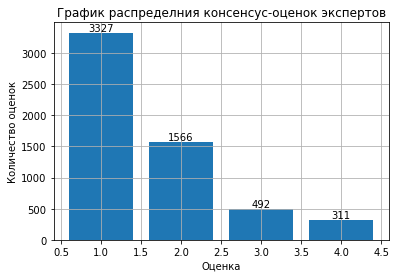

In [10]:
barplot = plt.bar(expert['final_score'].value_counts().index , height=expert['final_score'].value_counts().values)

plt.title('График распределния консенсус-оценок экспертов')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.bar_label(barplot, labels=expert['final_score'].value_counts().values)

plt.grid()
plt.show()

Переведем оценки в процентное соотношение, где:
- 1 - 0;
- 2 - .25;
- 3 - .67;
- 4 - 1

In [11]:
# функция нормирования оценки экспертов
def normalize(x):
    return (x-1)/(4-1)

In [12]:
expert['expert_rate'] = expert['final_score'].apply(normalize)

### Таблица с краудсорсинговыми оценками

In [13]:
crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   crowd_rate  47830 non-null  float64
 3   total_yes   47830 non-null  int64  
 4   total_no    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [14]:
crowd.tail()

image                    query_id  crowd_rate  \
47825  997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2    0.000000   
47826  997722733_0cb5439472.jpg  544576742_283b65fa0d.jpg#2    0.333333   
47827  997722733_0cb5439472.jpg  872622575_ba1d3632cc.jpg#2    1.000000   
47828  997722733_0cb5439472.jpg  888425986_e4b6c12324.jpg#2    0.000000   
47829  997722733_0cb5439472.jpg  997722733_0cb5439472.jpg#2    0.666667   

       total_yes  total_no  
47825          0         3  
47826          1         2  
47827          3         0  
47828          0         3  
47829          2         1

Проверим расчет доли соответствия описания изображению:

In [15]:
crowd['total_count'] = crowd['total_yes'] + crowd['total_no']
crowd['check'] = round((crowd['total_yes'] / crowd['total_count'] - crowd['crowd_rate']), 2)

In [16]:
crowd['check'].value_counts()

0.0    47830
Name: check, dtype: int64

Доля рассчитана верно. 

### Объединение оценок

Объединим оценки экспертов и краудосриснга в одну таблицу. 

In [17]:
all_scores = expert.merge(crowd, how='outer', left_on=['image', 'query_id'], right_on = ['image', 'query_id'])

In [18]:
all_scores = all_scores.dropna(subset=['expert_rate', 'crowd_rate'], how='all').reset_index(drop=True)

In [19]:
all_scores[['expert_rate', 'crowd_rate']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   expert_rate  5696 non-null   float64
 1   crowd_rate   47830 non-null  float64
dtypes: float64(2)
memory usage: 801.2 KB


Оценок экспертов меньше в ~6 раз, чем краудсорсинговых оценок. Чтобы максимально уведичить количество оценок запросов, посчитаем общую оценку по следующей формуле:
- если есть оценка эксперта и нет краудсорсинга: принимаем оценку эксперта финальной;
- если есть оценка краудсорсинга и нет эксперта: принимаем оценку краудсорсинга финальной;
- если есть обе оценки, считаем по формуле общую оценку: `P(expert)*0.6 + P(crowd)*0.4`;
- если нет обеих оценок: удаляем строку. 

In [20]:
# функция расчета общей оценки экспертов и краудсорсинга
def sum_score(data):
    if np.isnan(data['expert_rate']):
        x = data['crowd_rate']
    elif np.isnan(data['crowd_rate']):
        x = data['expert_rate']
    else:
        x = data['expert_rate'] * .6 + data['crowd_rate'] * .4
    return x

In [21]:
all_scores['rate'] = all_scores.apply(sum_score, axis=1)

In [22]:
data = all_scores[['image', 'query_id', 'rate']]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     51268 non-null  object 
 1   query_id  51268 non-null  object 
 2   rate      51268 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [24]:
data['rate'].value_counts()

0.000000    43708
0.333333     2757
1.000000     1292
0.666667     1207
0.200000      805
0.333333      656
0.400000      179
0.533333      142
0.250000       91
0.333333       79
0.666667       73
0.866667       62
0.666667       53
0.800000       37
0.500000       25
0.200000       20
0.733333       18
0.466667       18
0.600000       13
0.400000        8
0.750000        7
0.133333        4
0.166667        3
0.280000        2
0.560000        2
0.720000        2
0.300000        2
0.700000        2
0.100000        1
Name: rate, dtype: int64

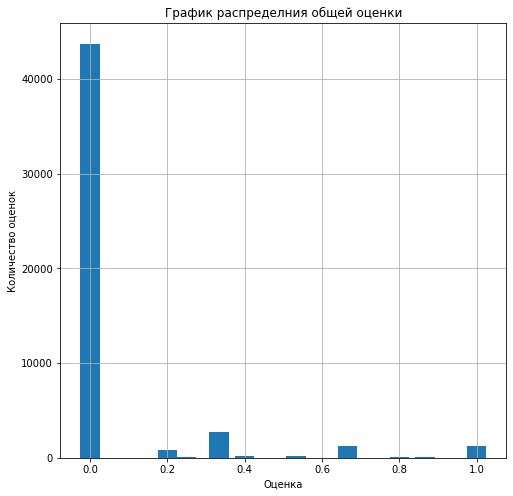

In [25]:
figure(figsize=(8, 8))

barplot = plt.bar(data['rate'].value_counts().index , height=data['rate'].value_counts().values, width=.05)

plt.title('График распределния общей оценки')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
#plt.bar_label(barplot, labels=data['rate'].value_counts().values)

plt.grid()
plt.show()

### Вывод

Данные с оценками экспертов и краудсорсинга не требуют коррекции и готовы для работы. 

Были рассчитаны вероятности соответствия текста и изображения экспертных оценок. Экспертные оценки и краудсорсинговые были объеденины в один датасет и рассчитана общая оценка по следующей формуле:
- если есть оценка эксперта и нет краудсорсинга: принимаем оценку эксперта финальной;
- если есть оценка краудсорсинга и нет эксперта: принимаем оценку краудсорсинга финальной;
- если есть обе оценки, считаем по формуле общую оценку: `P(expert)*0.6 + P(crowd)*0.4`;
- если нет обеих оценок: удаляем строку. 

Таким образом нам удалось расширить датасет вероятностей соответствия картинки и фразы. 

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### Идентификация запрещенных изображений

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [27]:
train_data['query_text'] = train_data['query_text'].str.lower()

In [28]:
# функция определения стоп-слов
def filter_child(data):
    for word in stop_words:
        if word in data['query_text']:
            return 1
    return 0

In [29]:
train_data['restrictive'] = train_data.apply(filter_child, axis=1)

In [30]:
train_data['restrictive'].value_counts()

0    4267
1    1555
Name: restrictive, dtype: int64

**Вывод:** 

1555 запросов содержат слова, которые описывают детей до 16 лет. Далее идентифицируем фотографии. 

In [31]:
def short_text(text):
    return text[:-2]

In [32]:
stop_images = train_data[train_data['restrictive'] == 1]['query_id'].apply(short_text).unique()

In [33]:
len(stop_images)

289

**Вывод:**

289 фотографии из 1000 в обучающей выборке относятся к запрещенному контенту. Удалим их из обучащей выборки. 

In [34]:
train_data_clear = train_data.query('image not in @stop_images')

In [35]:
train_data_clear = train_data_clear[['image', 'query_id', 'query_text']].reset_index(drop=True)

In [36]:
train_data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4096 non-null   object
 1   query_id    4096 non-null   object
 2   query_text  4096 non-null   object
dtypes: object(3)
memory usage: 96.1+ KB


### Визуальный конроль

Проведем визульный конроль результата чистки изображений:

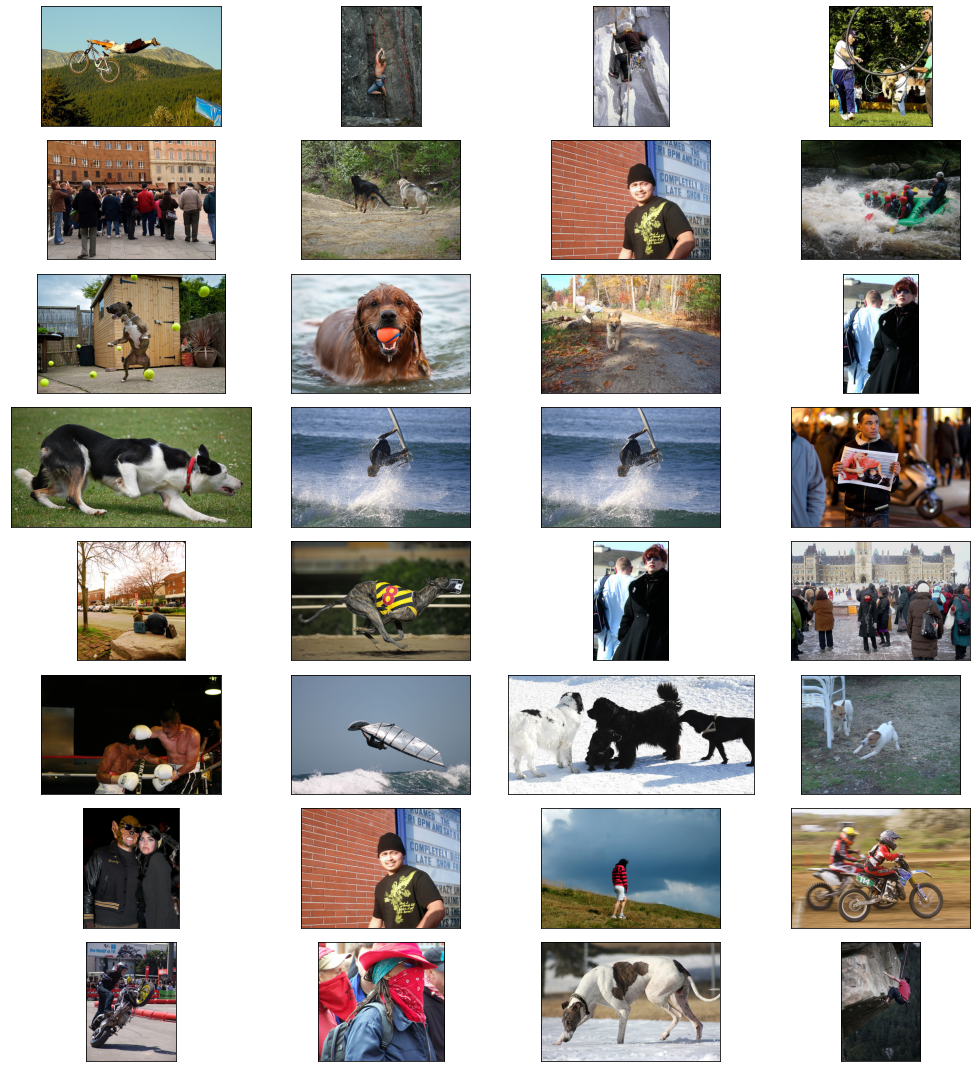

In [37]:
fig = plt.figure(figsize=(15, 15))

check_images = list(train_data_clear['image'].sample(32))

for i in range(32):
    fig.add_subplot(8, 4, i+1)
    image = Image.open(path + '/train_images/' + check_images[i])
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**

По итогам визуального контроля в выдаче не содержится ни одного изображения с детьми до 16 лет. Считаем, что чистка датасета проведена успешно. 

На следующем этапе объединим очищенный датасет с изображениями и оценками.

### Объединение датасетов

Объединим датасет с обучающей выборкой изображений с объединенным датасетом оценок. 

In [38]:
train_data_score = data.merge(train_data_clear, on=['image', 'query_id'], how='outer')

In [39]:
train_data_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51304 entries, 0 to 51303
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51304 non-null  object 
 1   query_id    51304 non-null  object 
 2   rate        51268 non-null  float64
 3   query_text  4096 non-null   object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


В результате объединения датасетов, большая часть текстовых запросов осталась не заполненной. Заполним пропущенные ячейки с помощью поиска текста запроса по идентификатору запроса:

In [40]:
# Функция заполнения пропущенных текстов запросов
def fillin(data):
    if pd.isnull(data['query_text']):
        txt = train_data[train_data['query_id'] == data['query_id']]['query_text']
    else: txt = data['query_text']
    return txt

In [41]:
train_data_score['query_text'] = train_data_score.apply(fillin, axis=1)

In [42]:
train_data_score.isna().sum()

image          0
query_id       0
rate          36
query_text     0
dtype: int64

Пропущенные текст запроса заполнен. 

Остались пропуски в оценках соответствия запроса и фотографии. В данном случае у нас нет дополнительных данных для заполнения. Удалим строки с пропущенными оценками:

In [43]:
train_data_score = train_data_score.dropna(subset=['rate']).reset_index(drop=True)

In [44]:
train_data_score.isna().sum()

image         0
query_id      0
rate          0
query_text    0
dtype: int64

**Вывод:**

Все пропуски хаполнены и удалены. Данные объединены корректно. 

### Вывод

Всего было идентифицировано:
- 1555 запросов, содержащих слова, которые описывают детей до 16 лет;
- 289 фотографии из 1000 в обучающей выборке относятся к запрещенному контенту.


Фотографии с детьми удалены из датасета. Также в обучающий датасет было добавлено поле с вероятностью соответствия описания. 

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

### Загрузчик файлов, ResNet50

Выведем образцы изображений для визуального контроля работы

In [45]:
# функция загрузки файлов для обучения
def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=train_data_score,
        directory=path + '/train_images/',
        x_col='image',
        y_col='rate',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=seed)

    return train_gen_flow

In [46]:
train_datagen = load_train(path)

Found 51268 validated image filenames.


In [47]:
X, y = next(train_datagen)

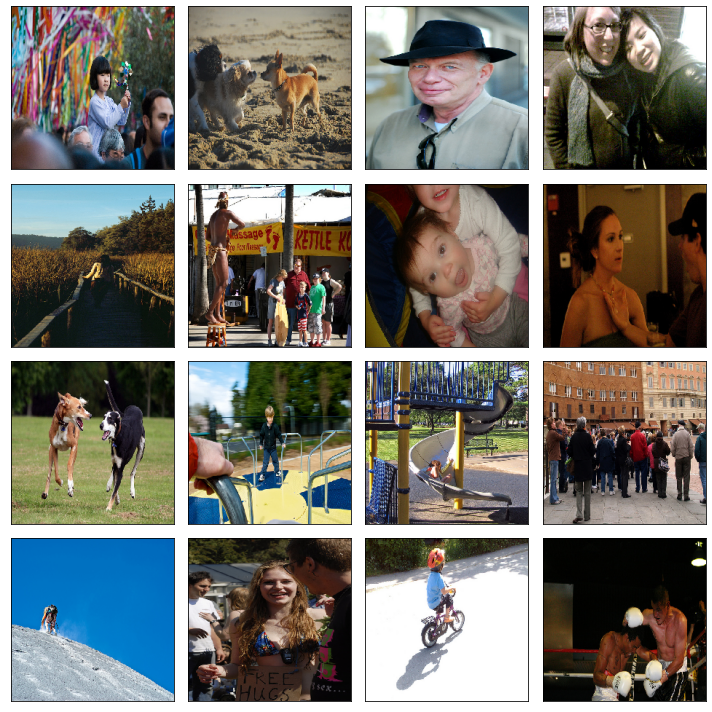

In [48]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Загрузчик файлов создан и работает корректно. Однако, в выдаче присутствуют фотографии с детьми, что может быть вызвано отсутствием в описании слов, описывающих детей, или некорректность оценки оценщиков. Стоит более тщательно маркировать фотографии перед работой.  

Инициализируем модель ResNet-50 для создания эмбедингов:

In [49]:
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', 
                  metrics=['mae'])
    return model

In [50]:
%%time

image_embad = create_model(input_shape=(224, 224, 3)).predict(load_train(path))

Found 51268 validated image filenames.


2023-06-22 14:55:06.293847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3205/3205 [==============================] - 3931s 1s/step
CPU times: user 4h 24min 2s, sys: 1h 34min 16s, total: 5h 58min 18s
Wall time: 1h 5min 36s


In [51]:
image_embad.shape

(51268, 2048)

### Вывод

Был создан загрузчик изображений и построена модель `ResNet50` без полносвязного слоя, чтобы не были посчитаны итоговые значения. 

Созданы эмбединги изображений. 

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [52]:
lemmatizer = WordNetLemmatizer()

# функция лемматизирования и очистки
def lemmitize(text):
    text = re.sub(r"[^a-zA-Z ]", ' ', str(text))
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(word) for word in text] # лемматирзируем слова
    return text

In [53]:
%%time

train_data_score['lemm_text'] = train_data_score['query_text'].apply(lemmitize)

CPU times: user 38.6 s, sys: 1.42 s, total: 40 s
Wall time: 40.6 s


In [54]:
# приведем к Юникоду:
corpus_train = train_data_score['lemm_text']
corpus_train = corpus_train.astype('U')
corpus_train.shape

(51268,)

In [55]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

cnt_tf_idf = TfidfVectorizer(stop_words=stopwords)
cnt_tf_idf.fit(corpus_train)

tf_idf_train = cnt_tf_idf.transform(corpus_train)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romanandreev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
print(tf_idf_train.shape)

(51268, 1466)


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Подскажи, пожалуйста, есть ли BERT в библиотеке Keras?
</div>

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [57]:
print(tf_idf_train.shape)
print(image_embad.shape)

(51268, 1466)
(51268, 2048)


In [59]:
X = np.concatenate((image_embad, tf_idf_train.toarray()), axis=1)
X.shape

(51268, 3514)

Признаки для обучения модели готовы. Итоговая размерность `X = (51268, 3514)`.

Выделим таргет в отдельный сет данных:

In [60]:
y = train_data_score['rate']
y.shape

(51268,)

**Вывод:**

Признаки и целевой признак подготовлены для обучения модели. Итоговые размерности:
- `X = (51268, 3514)`;
- `y = (51268,)`.

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Разделим данные на обучающие и тестовые выборки

In [61]:
from sklearn.model_selection import GroupShuffleSplit

In [62]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=seed)

train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_data_score['image']))

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [64]:
print(X_train.shape, 
      y_train.shape, 
      X_test.shape, 
      y_test.shape, 
      sep='\n')

(35697, 3514)
(35697,)
(15571, 3514)
(15571,)


**Вывод:** выборки для обчуения модели и теста созданы. 

Перед обучением моделей, определим задачу и выберем метрику качества. 



### LinearRegression

In [65]:
lr = LinearRegression(n_jobs=-1)

In [66]:
# params= {
#     'fit_intercept': [True], 
#     'copy_X': [True], 
#     'n_jobs': [None], 
#     'positive': [False]
# }

# grid_lr = GridSearchCV(estimator=lr, param_grid=params, cv=3, scoring='neg_root_mean_squared_error')

In [67]:
lr.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [68]:
predictions = lr.predict(X_test)

In [71]:
print(mean_squared_error(y_test, predictions, squared=False))

3047042.358877235


In [132]:
trg = pd.DataFrame(y_test.reset_index(drop=True))
prd = pd.DataFrame({'predictions': predictions})
qst = pd.concat([trg, prd], axis=1)

qst

rate  predictions
0      0.000000     0.225235
1      0.000000     0.287383
2      0.000000     0.288509
3      0.000000     0.186657
4      0.000000     0.112123
...         ...          ...
15566  0.000000    -0.026489
15567  0.000000    -0.042810
15568  0.333333     0.093601
15569  0.000000     0.023112
15570  0.000000     0.123090

[15571 rows x 2 columns]

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Подскажи, пожалуйста, по какой причине RMSE выглядит неправдоподобно? Если сравнить предсказания с таргетов, то порядок равный...

Так же странно, что в предсказаниях присутствует отрицательный RMSE. 
</div>

### NeuralNetwork

In [138]:
optimizer = Adam(lr=0.0001)

In [139]:
model_nn = Sequential()
model_nn.add(Dense(3514, input_shape=(X_train.shape[1],), activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(200, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(1, activation='relu'))

model_nn.compile(optimizer=optimizer, 
                 loss='mean_squared_error',
                 metrics=[RootMeanSquaredError()])

model_nn.build()

model_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 3514)              12351710  
                                                                 
 batch_normalization_4 (Batc  (None, 3514)             14056     
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 200)               703000    
                                                                 
 batch_normalization_5 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1)                 201       
                                                                 
Total params: 13,069,767
Trainable params: 13,062,339


In [140]:
model_nn.fit(X_train, 
             y_train,
             validation_data=(X_test, y_test),
             batch_size=16, 
             epochs=10,
             verbose=2, 
             shuffle=True)

Epoch 1/10
2232/2232 - 333s - loss: 0.0630 - root_mean_squared_error: 0.2509 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2175 - 333s/epoch - 149ms/step
Epoch 2/10
2232/2232 - 341s - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 341s/epoch - 153ms/step
Epoch 3/10
2232/2232 - 339s - loss: 0.0491 - root_mean_squared_error: 0.2217 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 339s/epoch - 152ms/step
Epoch 4/10
2232/2232 - 336s - loss: 0.0491 - root_mean_squared_error: 0.2217 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 336s/epoch - 151ms/step
Epoch 5/10
2232/2232 - 325s - loss: 0.0491 - root_mean_squared_error: 0.2217 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 325s/epoch - 146ms/step
Epoch 6/10
2232/2232 - 324s - loss: 0.0491 - root_mean_squared_error: 0.2217 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164 - 324s/epoch - 145ms/step
Epoch 7/10
2232/2232 - 326s - loss: 0.04

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Векторизация тестовых изображений

In [141]:
test_images = pd.DataFrame(test_queries['image'].unique(), columns=['image'])

In [142]:
test_images

image
0   1177994172_10d143cb8d.jpg
1   1232148178_4f45cc3284.jpg
2    123997871_6a9ca987b1.jpg
3   1319634306_816f21677f.jpg
4   1429546659_44cb09cbe2.jpg
..                        ...
95   862177617_c2c0581075.jpg
96   957682378_46c3b07bcd.jpg
97   973827791_467d83986e.jpg
98   989754491_7e53fb4586.jpg
99   989851184_9ef368e520.jpg

[100 rows x 1 columns]

In [143]:
# функция загрузки файлов для теста
def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=test_images,
        directory=path + '/test_images/',
        x_col='image',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=seed)

    return test_gen_flow

In [144]:
test_datagen = load_test(path)

Found 100 validated image filenames.


In [145]:
X, y = next(train_datagen)

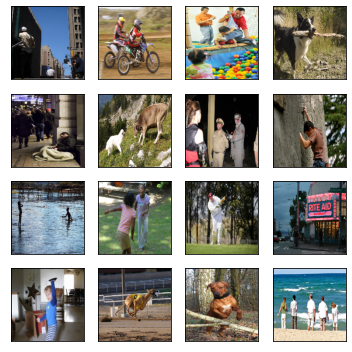

In [146]:
fig = plt.figure(figsize=(5, 5))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [147]:
%%time

test_image_embad = create_model(input_shape=(224, 224, 3)).predict(load_test(path))

Found 100 validated image filenames.


2023-06-22 17:52:18.040918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 7s 836ms/step
CPU times: user 28.6 s, sys: 10.3 s, total: 38.8 s
Wall time: 9.1 s


In [148]:
test_image_embad.shape

(100, 2048)

**Вывод:** эмбеддинги тестовых изображений созданы. Вышло 100 строк и 2048 полей. 

### Подготовка признаков для модели

Подготовим признаки для модели. Для этого векторизуем текс, проверим на стоп-слова и объединим вектор текстового запроса с вектором изображения, если стоп-слова не найдены. 

In [149]:
# функция обработки текста запроса и создания признаков

def get_feature(data):
    
    # лемматизация текстовых запросов
    data['query_text'] = data['query_text'].str.lower()
    data['lemmed'] = data['query_text'].apply(lemmitize)
    
    
    # приведем к Юникоду
    corpus_tst = data['lemmed']
    corpus_tst = corpus_tst.astype('U')
    
    
    # проверка на стоп-слова
    cntr = 0
    for word in stop_words:
        if word in data['lemmed'].values[0]:
            cntr += 1
    if cntr > 0:
        attaintion = 'This image is unavailable in your country in compliance with local laws.'
        return attaintion

           
    # токенизация текстовых запросов
    tf_idf_tst = cnt_tf_idf.transform(corpus_tst)
    
    
    # объединение эмбеддингов картинок и текста
    features = np.concatenate((test_image_embad[0].reshape(1, -1), tf_idf_tst.toarray()), axis=1)

    for i in range(1, len(test_image_embad)):
        f = np.concatenate((test_image_embad[i].reshape(1, -1), tf_idf_tst.toarray()), axis=1)
        features = np.concatenate((features, f), axis=0)    

    return features

Создадим массив из 10 случайно выбранных запросов. 

In [150]:
n = 10 # кол-во запросов для проверки
requests = test_queries.sample(n)

In [151]:
requests

query_id  \
478   862177617_c2c0581075.jpg#3   
443   440190907_bf8b7ba8ef.jpg#3   
336  3438981089_2ef1a6353c.jpg#1   
309  3386953179_84c2d7922f.jpg#4   
163  2709359730_13bca100af.jpg#3   
267  3184031654_34b5c4ffe1.jpg#2   
216  3044745642_1d0784ff29.jpg#1   
171  2737233999_34d60dc5c3.jpg#1   
24   1429546659_44cb09cbe2.jpg#4   
61   2107838729_a527e434bd.jpg#1   

                                            query_text  \
478  Man with brown coat and sunglasses wears a blu...   
443        People strolling through an indoor market .   
336  A man in a black t-shirt is jumping something ...   
309        Skier in red skiing down a snowy mountain .   
163        Several dogs are running through the dirt .   
267  Two women are wearing lavender scarves an thei...   
216  Men in a khaki-colored tent outside in a rundo...   
171  Four people are playing basketball on a plank ...   
24                 Two dogs stand in the brown grass .   
61    A boy in a blue shirt standing by a lake shore .   

                         image  
478   862177617_c2c0581075.jpg  
443   440190907_bf8b7ba8ef.jpg  
336  3438981089_2ef1a6353c.jpg  
309  3386953179_84c2d7922f.jpg  
163  2709359730_13bca100af.jpg  
267  3184031654_34b5c4ffe1.jpg  
216  3044745642_1d0784ff29.jpg  
171  2737233999_34d60dc5c3.jpg  
24   1429546659_44cb09cbe2.jpg  
61   2107838729_a527e434bd.jpg

Проведем тестирование модели на тестовых данных:

Your request: man with brown coat and sunglasses wears a blue wig and ball cap .
4/4 [==============================] - 0s 8ms/step
Your request: people strolling through an indoor market .
4/4 [==============================] - 0s 9ms/step
Your request: a man in a black t-shirt is jumping something on his orange bike .
4/4 [==============================] - 0s 8ms/step
Your request: skier in red skiing down a snowy mountain .
4/4 [==============================] - 0s 8ms/step
Your request: several dogs are running through the dirt .
4/4 [==============================] - 0s 7ms/step
Your request: two women are wearing lavender scarves an their heads .
4/4 [==============================] - 0s 8ms/step
Your request: men in a khaki-colored tent outside in a rundown area .
4/4 [==============================] - 0s 8ms/step
Your request: four people are playing basketball on a plank deck outdoors .
4/4 [==============================] - 0s 7ms/step
Your request: two dogs stand in the brow

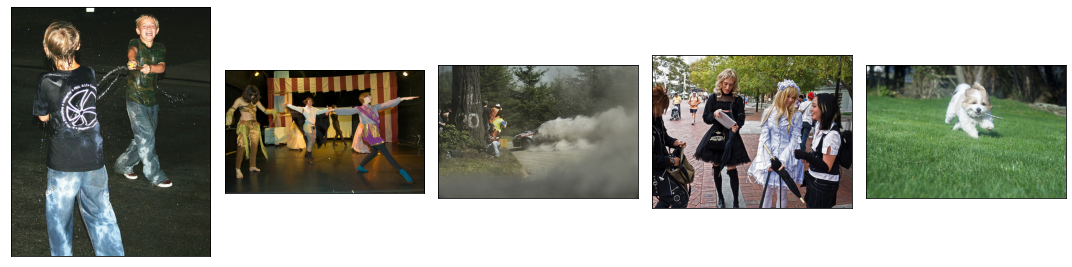

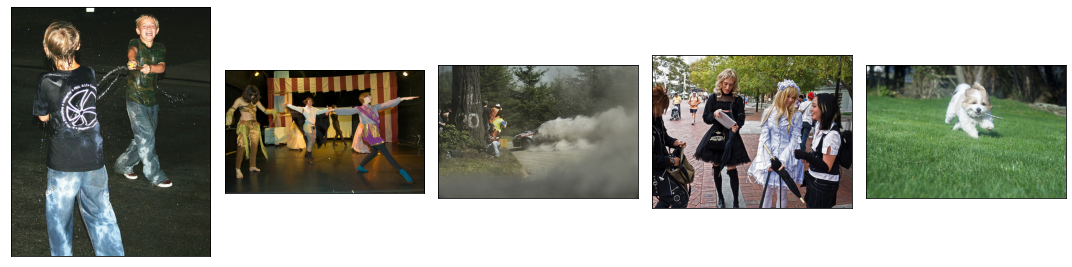

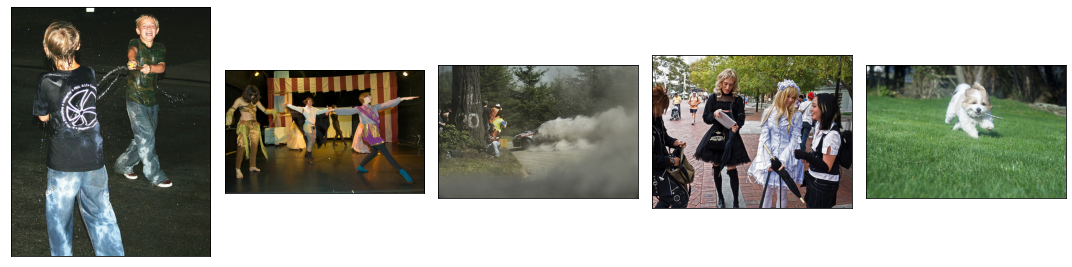

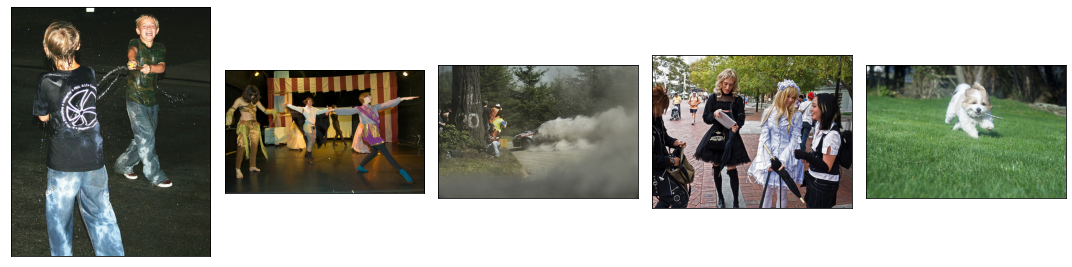

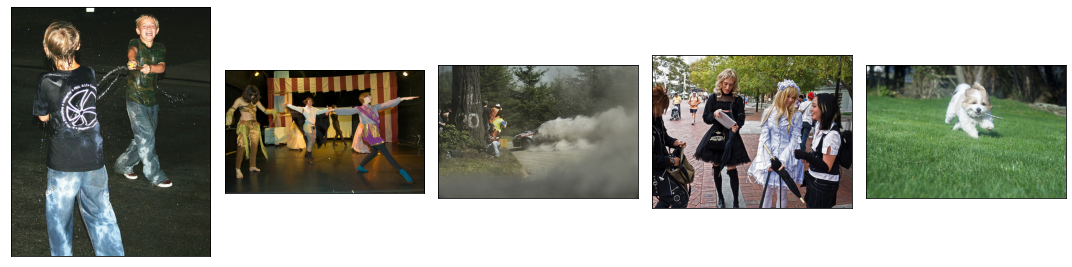

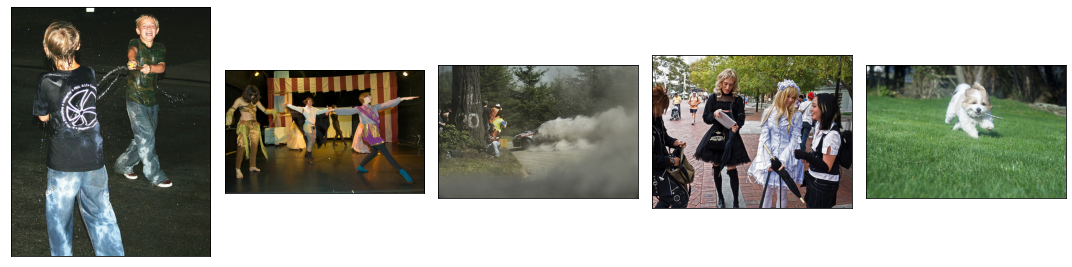

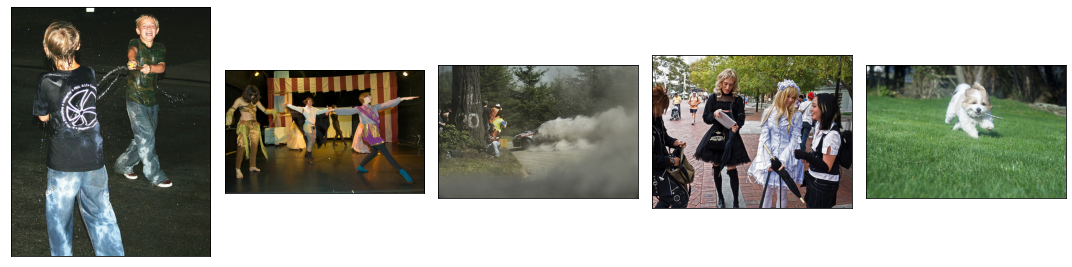

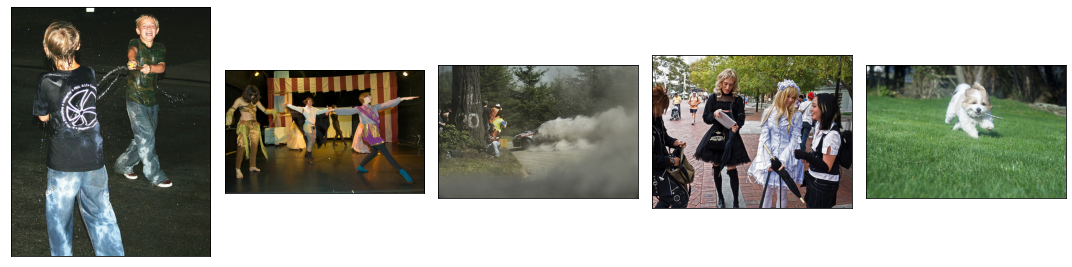

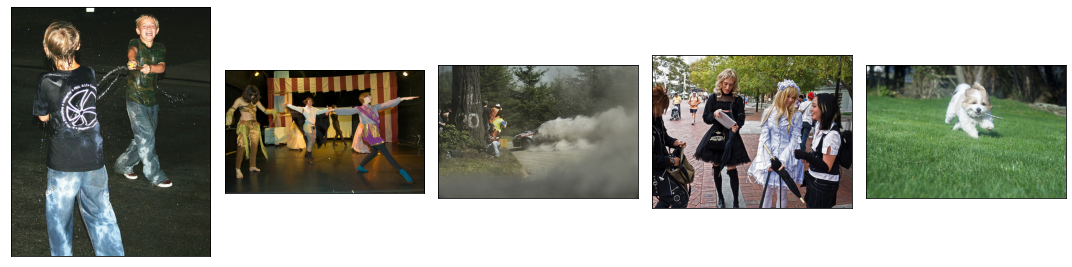

In [172]:
for i in requests.index:
    b = test_queries.iloc[i:i+1]
    features = get_feature(b)
    attaintion = 'This image is unavailable in your country in compliance with local laws.'
    print(f'Your request: {b["query_text"].values[0]}')
    
    if features == attaintion:
        print(f'{attaintion}')
    else:
        predictions = model_nn.predict(features)
    
        a = pd.Series([b['query_text'].values[0] for i in range(100)], name='request')
    
        preds = pd.DataFrame(predictions, columns=['score'])
        preds = pd.concat((preds, test_images['image'], a), axis=1)
    
        fig = plt.figure(figsize=(15, 15))

        check_images = preds.sort_values(by='score', ascending=False)['image'].head().values

        for i in range(5):
            fig.add_subplot(1, 5, i+1)
            image = Image.open(path + '/test_images/' + check_images[i])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Модель выдает один и тот же результат... Подскажи, пожалуйста, в чем может быть ошибка?
</div>

## Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска